In [127]:
import pandas as pd
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
os.getcwd()
path = "/home/julien/Documents/Projects/datasets/titanic"
os.chdir(path)

In [3]:
file = "titanic3.xls"

df = pd.read_excel(file, 
            #delimiter=r"\s+", 
            header=0,
            decimal = ".",
            #skiprows=[0],
            #keep_default_na=False
                )
df.shape          

(1309, 14)

In [89]:
# Munging pipeline
def start_pipeline(df):
    dataf = df.copy()
    return dataf
    
def extract_salutation(dataf):
    # Note: This method gives me one weird result with Jonkheer, 
    # but since he is alone, taking the mean won't affect the data
    dataf['salutation'] = (dataf.name
                         .str
                         .split('.',expand=True)
                         .loc[:,0]
                         .str
                         .split(',', expand=True)[1])
    return dataf

def correct_missing_age(dataf):
    # Calculate the median per salutation type
    dataf['age'] = (dataf
    .groupby(by='salutation')
    .age
    .apply(lambda d: d.fillna(d.median()))
    )
    return dataf

def port_of_embarcation(dataf):
    port_dict = {'S': 'Southampton', 
                 'C': 'Cherbourg',
                 'Q': 'Queenstown'}
    dataf['port_of_boarding'] = dataf['embarked'].map(port_dict)
    return dataf.drop(columns={'embarked'})

def passenger_class(dataf):
    class_dict = {1: "first",
                  2: "second",
                  3: "third"}
    dataf['class'] = dataf['pclass'].map(class_dict)
    return dataf

def age_cluster(dataf):
    agesplit = [0,10,18,25,40,90]
    agestatus = ['Adolescent','Teenager','Young Adult','Adult','Elder']
    dataf['age_group']=pd.cut(dataf.age,agesplit,labels=agestatus)
    return dataf

# OK so this is a dirty attempt to compute family size...
# Best would be to look at port of embarked, to differentiate families with same family name, like Smith
# TO IMPROVE
def family_aboard(dataf):   
    # Assign family name for future mapping
    dataf = dataf.assign(family_name = lambda d: d['name'].str.split(expand=True)[0].str.replace(',', ''))
    # Compute family count
    family_count = (dataf
    .groupby('family_name')
    .apply(lambda d: pd.Series({  
                "family_members": d['pclass'].count()
    }))
    .to_dict('index')
)
    # Not super elegant but fuck it, Im tired
    dataf = (dataf.assign(family_count = dataf['family_name'].map(family_count)))
    # Extract the actual family count
    dataf = (dataf.assign(family_count = [d.get('family_members') for d in dataf['family_count']]))
    return dataf.drop(columns={'pclass'})

# Note sure if the cabin means something, but maybe some were deeper in the boat
# I do not care about the number, simply the letter, which I guess indicates some deck
def cabin(dataf):
    dataf['deck'] = dataf['cabin'].str[0]
    return dataf

def rename_cols(dataf):
    dataf = dataf.rename(columns={'sibsp': 'siblings_spouse_aboard',
                                  'parch': 'parents_children_aboard'})
    return dataf

def logical_cols(dataf):
    dataf['siblings_spouse_aboard'] = dataf.siblings_spouse_aboard.astype(int)
    dataf['parents_children_aboard'] = dataf.siblings_spouse_aboard.astype(int)
    return dataf
    
# Some attributes like body have too many missing values
def drop_cols(dataf):
    return dataf.drop(columns={'body'})
    

In [90]:
df_clean.sample(1)

,survived,name,sex,age,siblings_spouse_aboard,parents_children_aboard,ticket,fare,cabin,boat,home.dest,salutation,port_of_boarding,class,age_group,family_name,family_count,deck
762,1,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.575,NaN,10,"Devon, England Wichita, KS",Master,Southampton,third,Adolescent,Dean,4,NaN


In [97]:
def select_ml_data(dataf):
    return dataf[['survived',
                  'sex',
                  'age_group',
                  'class',
                  #'salutation',
                  'deck',
                  'port_of_boarding',
                  'family_count',
                  'siblings_spouse_aboard',
                  'parents_children_aboard']]

def prepare_ml_data(dataf):
    # Getting Dummies from all other categorical vars
    for col in dataf.dtypes[dataf.dtypes == 'object'].index:
        # Get rid of current object column
             for_dummy = dataf.pop(col)
             dataf = pd.concat([dataf, pd.get_dummies(for_dummy, prefix=col)], axis=1)
    return dataf

In [98]:
# Run pipeline
df_clean = (df
.pipe(start_pipeline)
.pipe(extract_salutation)
.pipe(correct_missing_age)
.pipe(port_of_embarcation)
.pipe(passenger_class)
.pipe(age_cluster)
.pipe(family_aboard)
.pipe(cabin)
.pipe(rename_cols)
.pipe(logical_cols)
.pipe(drop_cols)
           )

In [100]:
df_clean.sample(1)

,survived,name,sex,age,siblings_spouse_aboard,parents_children_aboard,ticket,fare,cabin,boat,home.dest,salutation,port_of_boarding,class,age_group,family_name,family_count,deck
621,1,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,1,350046,7.8542,NaN,16,NaN,Miss,Southampton,third,Young Adult,Andersen-Jensen,1,NaN


In [101]:
#Checking for missing data
NAs = pd.concat([df_clean.isnull().sum()], axis=1, keys=['NAs'])
NAs[NAs.sum(axis=1) > 0]

,NAs
fare,1
cabin,1014
boat,823
home.dest,564
port_of_boarding,2
deck,1014


In [102]:
df_ml = (df_clean
.pipe(start_pipeline)
.pipe(select_ml_data)
.pipe(prepare_ml_data)
            )

In [104]:
df_ml.columns

Index(['survived', 'age_group', 'family_count', 'siblings_spouse_aboard',
       'parents_children_aboard', 'sex_female', 'sex_male', 'class_first',
       'class_second', 'class_third', 'deck_A', 'deck_B', 'deck_C', 'deck_D',
       'deck_E', 'deck_F', 'deck_G', 'deck_T', 'port_of_boarding_Cherbourg',
       'port_of_boarding_Queenstown', 'port_of_boarding_Southampton'],
      dtype='object')

## Model Fit

In [108]:
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split

In [109]:
X = df_ml.drop(columns={'survived'})
y = df_ml['survived']

In [110]:
# Clean up x by getting the dummies
X = pd.get_dummies(X)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [112]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier(max_depth=3)
clftree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

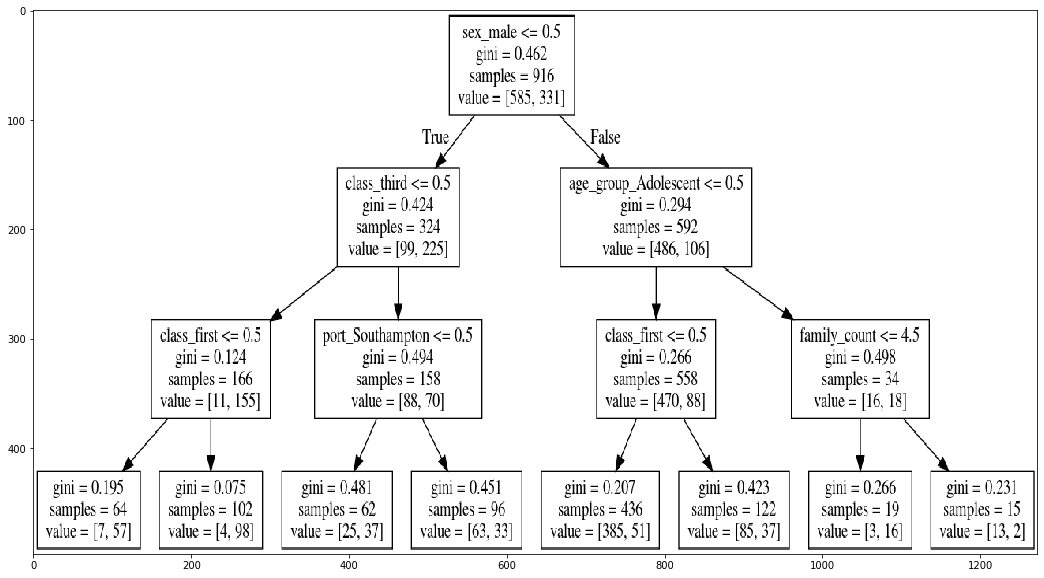

In [34]:
# Visualizing the decision tree
from sklearn import tree
from scipy import misc
import pydotplus
import graphviz
import matplotlib.pyplot as plt
import imageio

def show_tree(decisionTree, file_path):
    tree.export_graphviz(decisionTree, out_file='tree.dot',feature_names=X_train.columns)
    graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')
    graph.write_png('tree.png')
    i = imageio.imread(file_path)
    
    fig, ax = plt.subplots(figsize=(18, 10))    
    ax.imshow(i, aspect='auto')

# To use it
show_tree(clftree, 'tree.png')

In [150]:
from sklearn.metrics import accuracy_score, log_loss, auc, precision_score, recall_score

print('**** Results Decision Tree ****')
train_predictions = clftree.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
pre = precision_score(y_test, train_predictions)
rec = recall_score(y_test, train_predictions)
#auc = auc(y_test, train_predictions)

# Accuracy = [TruePositive + TrueNegative]/ Total
print("Accuracy: {:.4%}".format(acc))
# Precision = TruePositive / [TruePositive + FalsePositive]
print("Precision: {:.4%}".format(pre))
# PRecall = TruePositive / [TruePositive + FalseNegative]
print("Recall: {:.4%}".format(rec))
#print("AUC: {:.4%}".format(auc))

**** Results Decision Tree ****
Accuracy: 79.8982%
Precision: 86.8852%
Recall: 62.7219%


[[208  16]
 [ 63 106]]


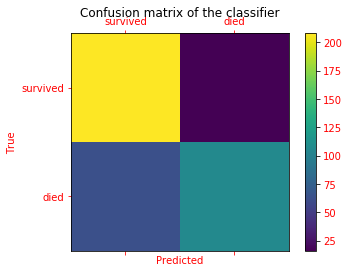

In [143]:
from sklearn.metrics import confusion_matrix
labels = ['survived', 'died']
cm = confusion_matrix(y_test, train_predictions)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
#fig.colorbar(cax)
color_bar = plt.colorbar(cax)                          
cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')  # tricky
plt.setp(cbytick_obj, color='r')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.tick_params(axis='x', colors='red')
ax.tick_params(axis='y', colors='red')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Let's try the logistic regression

In [144]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression() #logistic regression using python
logreg.fit(X_train, 
           y_train)

/home/julien/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [145]:
y_pred = logreg.predict(X_test) #predicting the values
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [151]:
print('**** Results Logistic Regression ****')
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
#auc = auc(y_test, train_predictions)

# Accuracy = [TruePositive + TrueNegative]/ Total
print("Accuracy: {:.4%}".format(acc))
# Precision = TruePositive / [TruePositive + FalsePositive]
print("Precision: {:.4%}".format(pre))
# Recall = TruePositive / [TruePositive + FalseNegative]
print("Recall: {:.4%}".format(rec))
#print("AUC: {:.4%}".format(auc))

**** Results Logistic Regression ****
Accuracy: 78.8804%
Precision: 81.1594%
Recall: 66.2722%


In [159]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[198,  26],
       [ 57, 112]])

In [158]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True, gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    pre = precision_score(y_test, train_predictions)
    rec = recall_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
        
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 77.8626%
Precision: 82.0312%
Recall: 62.1302%
Log Loss: 3.3276028472462005
DecisionTreeClassifier
****Results****
Accuracy: 77.6081%
Precision: 82.4000%
Recall: 60.9467%
Log Loss: 4.694853380619004
RandomForestClassifier
****Results****
Accuracy: 77.8626%
Precision: 82.5397%
Recall: 61.5385%
Log Loss: 1.556717046685071
AdaBoostClassifier
****Results****
Accuracy: 80.1527%
Precision: 80.5369%
Recall: 71.0059%
Log Loss: 0.6786411148717828
GradientBoostingClassifier
****Results****
Accuracy: 79.6438%
Precision: 85.6000%
Recall: 63.3136%
Log Loss: 0.453766830178001
GaussianNB
****Results****
Accuracy: 70.7379%
Precision: 60.7143%
Recall: 90.5325%
Log Loss: 2.25182977006919
LinearDiscriminantAnalysis
****Results****
Accuracy: 79.3893%
Precision: 80.5556%
Recall: 68.6391%
Log Loss: 0.4637077232816431
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 60.8142%
Precision: 62.2951%
Recall: 22.4852%
Log Loss: 9.153141217571918


/home/julien/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/julien/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/julien/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
